<a href="https://colab.research.google.com/github/YITRALOP/NMA/blob/main/tutorials/W1D2_ModelFitting/student/W1D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Linear regression with MSE

**Week 1, Day 2: Model Fitting**

**By Neuromatch Academy**

**Content creators**: Pierre-Étienne Fiquet, Anqi Wu, Alex Hyafil with help from Byron Galbraith

**Content reviewers**: Lina Teichmann, Saeed Salehi, Patrick Mineault,  Ella Batty, Michael Waskom

**Production editors**: Spiros Chavlis

___
# Tutorial Objectives

*Estimated timing of tutorial: 30 minutes*

This is Tutorial 1 of a series on fitting models to data. We start with simple linear regression, using least squares optimization (Tutorial 1) and Maximum Likelihood Estimation (Tutorial 2). We will use bootstrapping to build confidence intervals around the inferred linear model parameters (Tutorial 3). We'll finish our exploration of regression models by generalizing to multiple linear regression and polynomial regression (Tutorial 4). We end by learning how to choose between these various models. We discuss the bias-variance trade-off (Tutorial 5) and Cross Validation for model selection (Tutorial 6).

In this tutorial, we will learn how to fit simple linear models to data.
- Learn how to calculate the mean-squared error (MSE)
- Explore how model parameters (slope) influence the MSE
- Learn how to find the optimal model parameter using least-squares optimization

<br>

**Acknowledgements:**
- We thank Eero Simoncelli. Much of today's tutorials are inspired by exercises assigned in his mathtools class.

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
link_id = "2mkq4"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [16]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W1D2_T1"

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [6]:
# @title Plotting Functions

def plot_observed_vs_predicted(x, y, y_hat, theta_hat):
  """ Plot observed vs predicted data

  Args:
    x (ndarray): observed x values
    y (ndarray): observed y values
    y_hat (ndarray): predicted y values
    theta_hat (ndarray):
  """
  fig, ax = plt.subplots()
  ax.scatter(x, y, label='Observed')  # our data scatter plot
  ax.plot(x, y_hat, color='r', label='Fit')  # our estimated model
  # plot residuals
  ymin = np.minimum(y, y_hat)
  ymax = np.maximum(y, y_hat)
  ax.vlines(x, ymin, ymax, 'g', alpha=0.5, label='Residuals')
  ax.set(
      title=fr"$\hat{{\theta}}$ = {theta_hat:0.2f}, MSE = {np.mean((y - y_hat)**2):.2f}",
      xlabel='x',
      ylabel='y'
  )
  ax.legend()
  plt.show()

---
# Section 1: Mean Squared Error (MSE)

In [6]:
# @title Video 1: Linear Regression & Mean Squared Error
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'HumajfjJ37E'), ('Bilibili', 'BV1tA411e7NW')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Mean_Squared_Error_Video")

This video covers a 1D linear regression and mean squared error.

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

**Linear least squares regression** is an old but gold  optimization procedure that we are going to use for data fitting. Least squares (LS) optimization problems are those in which the objective function is a quadratic function of the
parameter(s) being optimized.

Suppose you have a set of measurements: for each data point or measurement, you have $y_{i}$ (the "dependent" variable) obtained for a different input value, $x_{i}$ (the "independent" or "explanatory" variable).  Suppose we believe the measurements are proportional to the input values, but are corrupted by some (random) measurement errors, $\epsilon_{i}$, that is:

\begin{equation}
y_{i}= \theta x_{i}+\epsilon_{i}
\end{equation}

for some unknown slope parameter $\theta.$ The least squares regression problem uses **mean squared error (MSE)** as its objective function, it aims to find the value of the parameter $\theta$ by minimizing the average of squared errors:

\begin{equation}
\min _{\theta} \frac{1}{N}\sum_{i=1}^{N}\left(y_{i}-\theta x_{i}\right)^{2}
\end{equation}

We will now explore how MSE is used in fitting a linear regression model to data. For illustrative purposes, we will create a simple synthetic dataset where we know the true underlying model. This will allow us to see how our estimation efforts compare in uncovering the real model (though in practice we rarely have this luxury).

First we will generate some noisy samples $x$ from [0, 10) along the line $y = 1.2x$ as our dataset we wish to fit a model to.

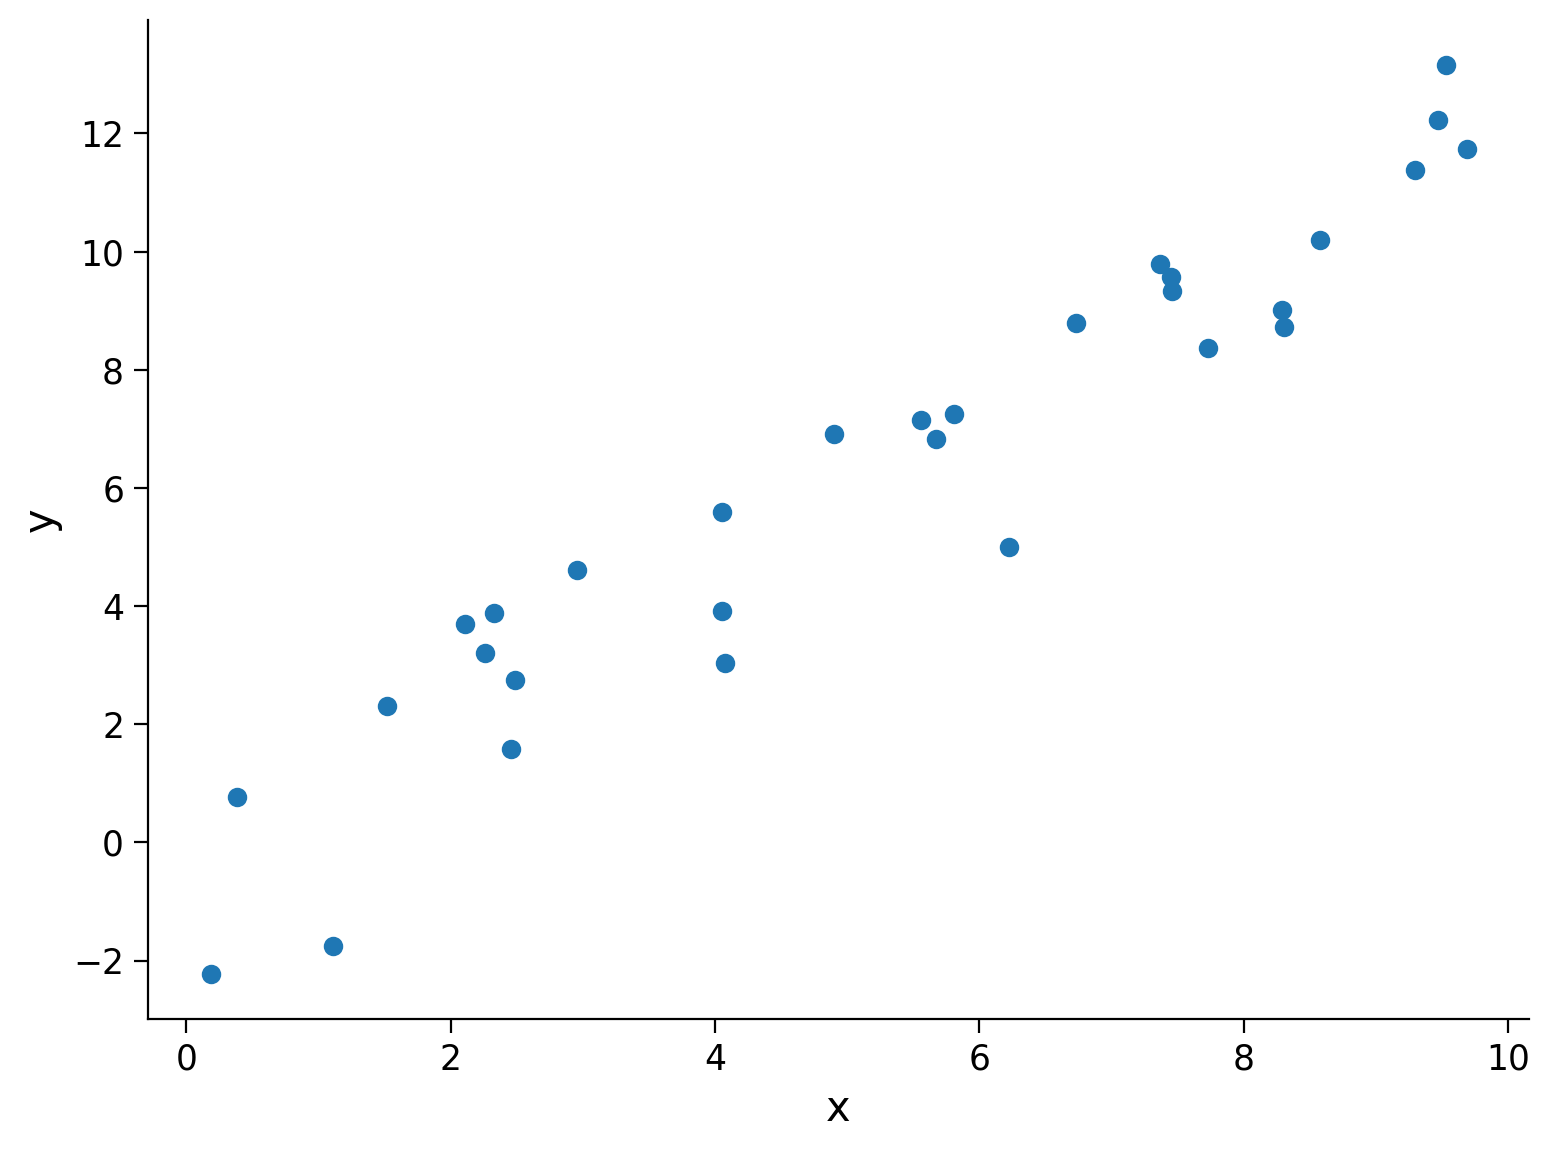

In [7]:
# @title

# @markdown Execute this cell to generate some simulated data

# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)

# Let's set some parameters
theta = 1.2
n_samples = 30

# Draw x and then calculate y
x = 10 * np.random.rand(n_samples)  # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples)  # sample from a standard normal distribution
y = theta * x + noise

# Plot the results
fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

Now that we have our suitably noisy dataset, we can start trying to estimate the underlying model that produced it. We use MSE to evaluate how successful a particular slope estimate $\hat{\theta}$ is for explaining the data, with the closer to 0 the MSE is, the better our estimate fits the data.

## Coding Exercise 1: Compute MSE

In this exercise you will implement a method to compute the mean squared error for a set of inputs $\mathbf{x}$, measurements $\mathbf{y}$, and slope estimate $\hat{\theta}$. Here, $\mathbf{x}$ and $\mathbf{y}$ are vectors of data points. We will then compute and print the mean squared error for 3 different choices of theta.

As a reminder, the equation for computing the estimated y for a single data point is:

\begin{equation}
\hat{y}_{i}= \theta x_{i}
\end{equation}

and for mean squared error is:

\begin{equation}
\min _{\theta} \frac{1}{N}\sum_{i=1}^{N}\left(y_{i}-\hat{y}_i\right)^{2}
\end{equation}

In [14]:
def mse(x, y, theta_hat):
  """Compute the mean squared error

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    theta_hat (float): An estimate of the slope parameter

  Returns:
    float: The mean squared error of the data with the estimated parameter.
  """
  ####################################################
  ## TODO for students: compute the mean squared error
  # Fill out function and remove
  # raise NotImplementedError("Student exercise: compute the mean squared error")
  ####################################################

  # Compute the estimated y
  y_hat = theta_hat * x

  # Compute mean squared error
  mse = np.mean((y - y_hat)**2)

  return mse


theta_hats = [0.75, 1.0, 1.5]
for theta_hat in theta_hats:
  print(f"theta_hat of {theta_hat} has an MSE of {mse(x, y, theta_hat):.2f}")

(30,)
theta_hat of 0.75 has an MSE of 9.08
(30,)
theta_hat of 1.0 has an MSE of 3.01
(30,)
theta_hat of 1.5 has an MSE of 4.52


The result should be:

```
theta_hat of 0.75 has an MSE of 9.08\
theta_hat of 1.0 has an MSE of 3.0\
theta_hat of 1.5 has an MSE of 4.52
```




[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D2_ModelFitting/solutions/W1D2_Tutorial1_Solution_12a57de0.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Compute_MSE_Exercise")

We see that $\hat{\theta} = 1.0$ is our best estimate from the three we tried. Looking just at the raw numbers, however, isn't always satisfying, so let's visualize what our estimated model looks like over the data.



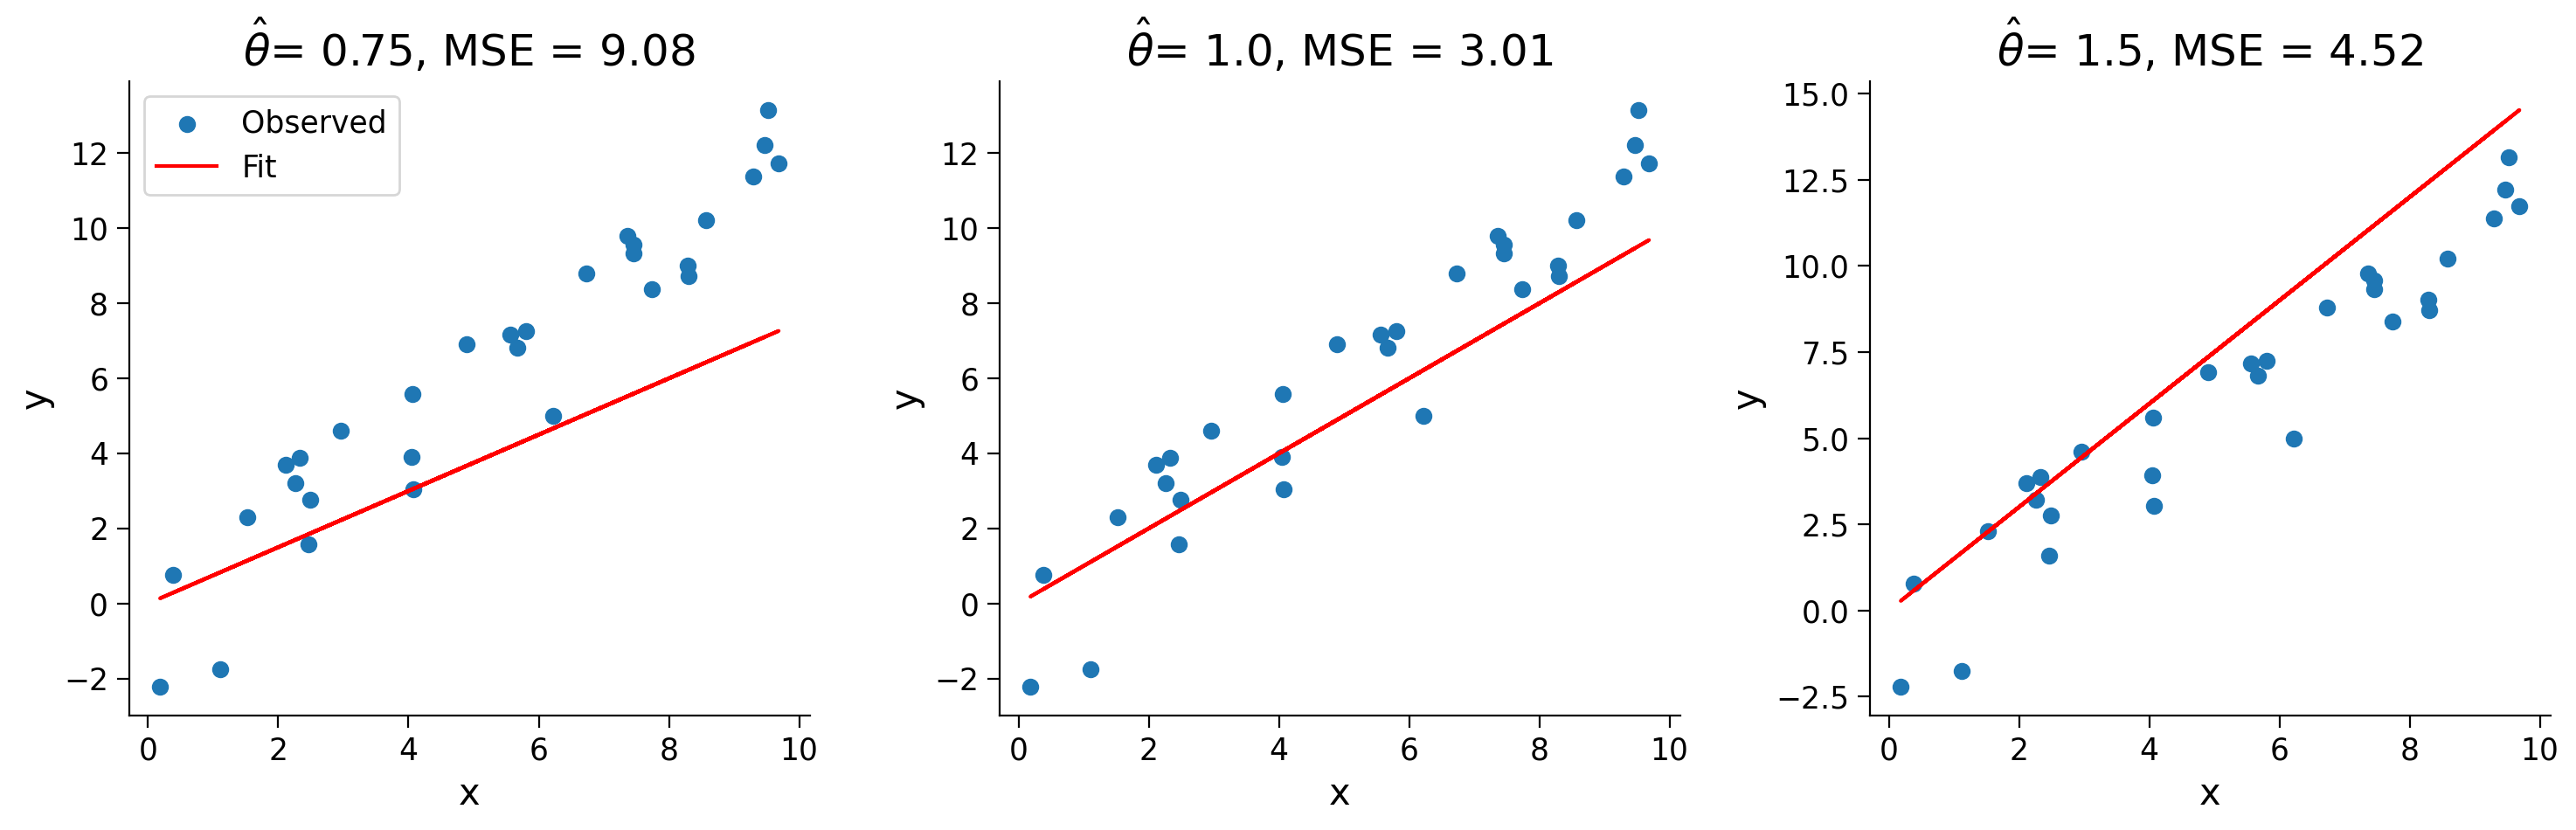

In [15]:
# @markdown Execute this cell to visualize estimated models

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for theta_hat, ax in zip(theta_hats, axes):

  # True data
  ax.scatter(x, y, label='Observed')  # our data scatter plot

  # Compute and plot predictions
  y_hat = theta_hat * x
  ax.plot(x, y_hat, color='r', label='Fit')  # our estimated model

  ax.set(
      title= fr'$\hat{{\theta}}$= {theta_hat}, MSE = {np.mean((y - y_hat)**2):.2f}',
      xlabel='x',
      ylabel='y'
  );

axes[0].legend()
plt.show()

## Interactive Demo 1: MSE Explorer

Using an interactive widget, we can easily see how changing our slope estimate changes our model fit. We display the **residuals**, the differences between observed and predicted data, as line segments between the data point (observed response) and the corresponding predicted response on the model fit line.

- What value of $\hat{\theta}$ results in the lowest MSE?
- Is this a good way of estimating $\theta$?


In [17]:
# @markdown Make sure you execute this cell to enable the widget!
@widgets.interact(theta_hat=widgets.FloatSlider(1.0, min=0.0, max=2.0))
def plot_data_estimate(theta_hat):
  y_hat = theta_hat * x
  plot_observed_vs_predicted(x, y, y_hat, theta_hat)

interactive(children=(FloatSlider(value=1.0, description='theta_hat', max=2.0), Output()), _dom_classes=('widg…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D2_ModelFitting/solutions/W1D2_Tutorial1_Solution_dff242e7.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_MSE_explorer_Interactive_Demo_Discussion")

While visually exploring several estimates can be instructive, it's not the most efficient for finding the best estimate to fit our data. Another technique we can use is to choose a reasonable range of parameter values and compute the MSE at several values in that interval. This allows us to plot the error against the parameter value (this is also called an **error landscape**, especially when we deal with more than one parameter). We can select the final $\hat{\theta}$  ($\hat{\theta}_\textrm{MSE}$) as the one which results in the lowest error.

In [ ]:
# @markdown Execute this cell to loop over theta_hats, compute MSE, and plot results

# Loop over different thetas, compute MSE for each
theta_hat_grid = np.linspace(-2.0, 4.0)
errors = np.zeros(len(theta_hat_grid))
for i, theta_hat in enumerate(theta_hat_grid):
  errors[i] = mse(x, y, theta_hat)

# Find theta that results in lowest error
best_error = np.min(errors)
theta_hat = theta_hat_grid[np.argmin(errors)]


# Plot results
fig, ax = plt.subplots()
ax.plot(theta_hat_grid, errors, '-o', label='MSE', c='C1')
ax.axvline(theta, color='g', ls='--', label=r"$\theta_{True}$")
ax.axvline(theta_hat, color='r', ls='-', label=r"$\hat{{\theta}}_{MSE}$")
ax.set(
  title=fr"Best fit: $\hat{{\theta}}$ = {theta_hat:.2f}, MSE = {best_error:.2f}",
  xlabel=r"$\hat{{\theta}}$",
  ylabel='MSE')
ax.legend()
plt.show()

We can see that our best fit is $\hat{\theta}=1.18$ with an MSE of 1.45. This is quite close to the original true value $\theta=1.2$!


---
# Section 2: Least-squares optimization

*Estimated timing to here from start of tutorial: 20 min*

While the approach detailed above (computing MSE at various values of $\hat\theta$) quickly got us to a good estimate, it still relied on evaluating the MSE value across a grid of hand-specified values. If we didn't pick a good range to begin with, or with enough granularity, we might miss the best possible estimator. Let's go one step further, and instead of finding the minimum MSE from a set of candidate estimates, let's solve for it analytically.

We can do this by minimizing the cost function. Mean squared error is a convex objective function, therefore we can compute its minimum using calculus. Please see video or Bonus Section 1 for this derivation! After computing the minimum, we find that:

\begin{equation}
\hat\theta = \frac{\mathbf{x}^\top \mathbf{y}}{\mathbf{x}^\top \mathbf{x}}
\end{equation}

where $\mathbf{x}$ and $\mathbf{y}$ are vectors of data points.

This is known as solving the normal equations. For different ways of obtaining the solution, see the notes on [Least Squares Optimization](https://www.cns.nyu.edu/~eero/NOTES/leastSquares.pdf) by Eero Simoncelli.

## Coding Exercise 2: Solve for the Optimal Estimator

In this exercise, you will write a function that finds the optimal $\hat{\theta}$ value using the least squares optimization approach (the equation above) to solve MSE minimization. It should take arguments $x$ and $y$ and return the solution $\hat{\theta}$.

We will then use your function to compute $\hat{\theta}$ and plot the resulting prediction on top of the data.

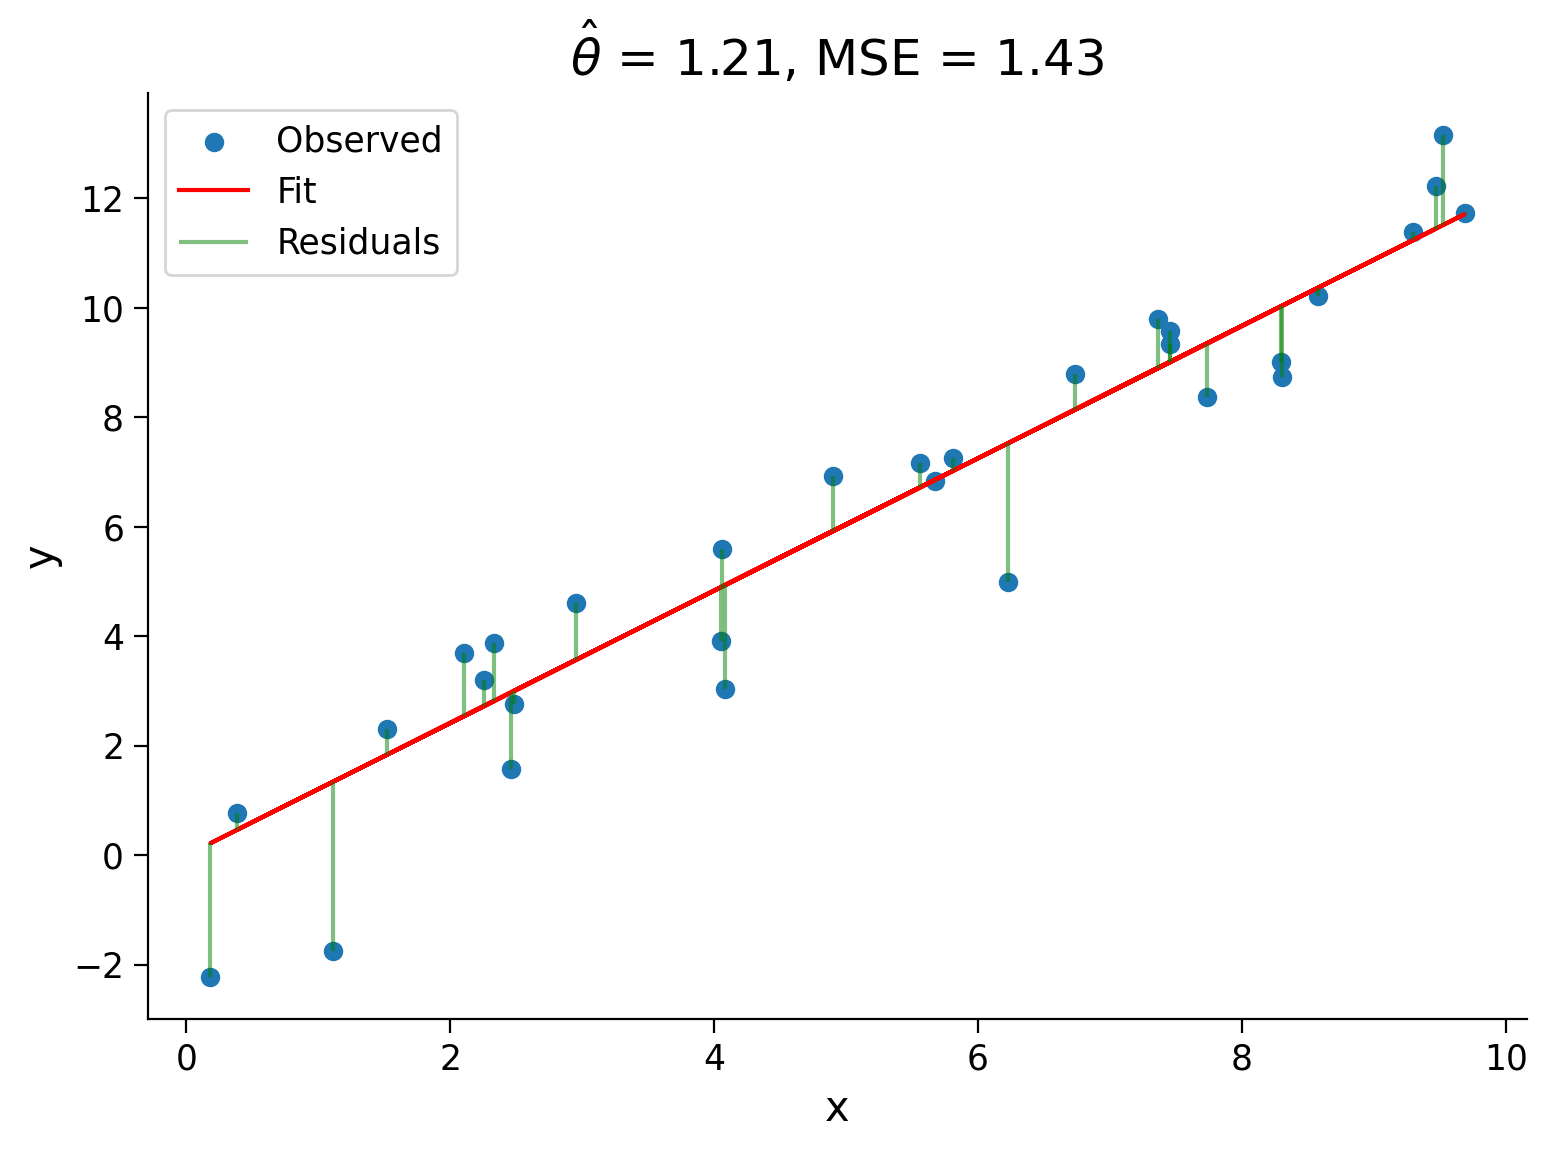

In [18]:
def solve_normal_eqn(x, y):
  """Solve the normal equations to produce the value of theta_hat that minimizes
    MSE.

    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    float: the value for theta_hat arrived from minimizing MSE
  """

  ################################################################################
  ## TODO for students: solve for the best parameter using least squares
  # Fill out function and remove
  # raise NotImplementedError("Student exercise: solve for theta_hat using least squares")
  ################################################################################

  # Compute theta_hat analytically
  theta_hat = np.sum(x * y) / np.sum(x**2)

  return theta_hat


theta_hat = solve_normal_eqn(x, y)
y_hat = theta_hat * x
plot_observed_vs_predicted(x, y, y_hat, theta_hat)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D2_ModelFitting/solutions/W1D2_Tutorial1_Solution_7a89ba24.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D2_ModelFitting/static/W1D2_Tutorial1_Solution_7a89ba24_0.png>



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Solve_for_the_Optimal_Estimator_Exercise")

We see that the analytic solution produces an even better result than our grid search from before, producing $\hat{\theta} = 1.21$ with $\text{MSE} = 1.43$!

---
# Summary

*Estimated timing of tutorial: 30 minutes*

Linear least squares regression is an optimization procedure that can be used for data fitting:

  - Task: predict a value for $y_i$ given $x_i$
  - Performance measure: $\textrm{MSE}$
  - Procedure: minimize $\textrm{MSE}$ by solving the normal equations

**Key point**: We fit the model by defining an *objective function* and minimizing it.

**Note**: In this case, there is an *analytical* solution to the minimization problem and in practice, this solution can be computed using *linear algebra*. This is *extremely* powerful and forms the basis for much of numerical computation throughout the sciences.

---
# Notation

\begin{align}
x_{i} &\quad \text{input, independent variable}\\
y_{i} &\quad \text{measurement, dependent variable}\\
\mathbf{x} &\quad \text{vector of input values}\\
\mathbf{y} &\quad \text{vector of measurements}\\
\hat{y}_{i} &\quad \text{estimate of dependent variable}\\
\epsilon_{i} &\quad \text{measurement error}\\
\theta &\quad \text{slope parameter}\\
\hat{\theta} &\quad \text{estimated slope parameter}\\
\hat{\theta}_\text{MSE} &\quad \text{slope parameter estimated via the mean squared error}\\
\textrm{MSE} &\quad \text{mean squared error}\\
\end{align}

---
# Bonus

## Bonus Section 1: Least Squares Optimization Derivation

We will outline here the derivation of the least squares solution.

We first set the derivative of the error expression with respect to $\theta$ equal to zero,

\begin{align}
\frac{d}{d\theta}\frac{1}{N}\sum_{i=1}^N(y_i - \theta x_i)^2 &= 0 \\
\frac{1}{N}\sum_{i=1}^N-2x_i(y_i - \theta x_i) &= 0
\end{align}

where we used the chain rule. Now solving for $\theta$, we obtain an optimal value of:

\begin{equation}
\hat\theta = \frac{\sum_{i=1}^N x_i y_i}{\sum_{i=1}^N x_i^2}
\end{equation}

Which we can write in vector notation as:

\begin{equation}
\hat\theta = \frac{\mathbf{x}^\top \mathbf{y}}{\mathbf{x}^\top \mathbf{x}}
\end{equation}

<br>

This is known as solving the *normal equations*. For different ways of obtaining the solution, see the notes on [Least Squares Optimization](https://www.cns.nyu.edu/~eero/NOTES/leastSquares.pdf) by Eero Simoncelli.